In [2]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

import numpy as np
import astropy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [52]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class AetasStellae():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,feh,cnalpha,obsphot,obsphot_err,distance,isochrones,rv=3.1):
        
        '''
        teff: [float] Teff of star
        feh: [float] metallicity [Fe/H] of star
        cnalpha: [array] [C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe]
        phot: [array] observed [BP,RP,J,H,K] photometry
        phot_err: [array] observed [BP,RP,J,H,K] photometry error
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff # temperature
        self.salfeh = self.salariscorrectedfeh(feh,cnalpha) # Metallicity
        self.phot = obsphot # photometry
        self.phot_err = obsphot_err # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    def salariscorrectedfeh(self,feh,cnalpha):
        '''
        Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
        Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
        Inputs:
        ------
            feh: metallcity of a star
            cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
        Output:
        ------
            salfeh: Salaris corrected metallicity
        '''
        # hydrogen_wgt = 1.008 #IUPAC
        # atomic_wgts = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
        # asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
        # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
        # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
        # b = 1-a # b = 0.21036372868803943
        
        asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
        # assign solar value to stars if abundance is bad
        for j in range(len(cnalpha)):
            if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
                cnalpha[j] = 0.0
                
        if np.isfinite(feh)==False:
            feh = 0.0
        
        # Calculate enhancement factor and corrected metallicity
        fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
        salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
        return salfeh 
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation (MAD) of data
        
        Input:
        -----
            data: data to calculate the MAD of 
        '''
        
        return np.nanmedian(np.abs(np.subtract(data,np.nanmedian(data))))
    
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def ccm_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav    
        
    def k_extinction(self,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        n = 100
        ind = np.floor(np.random.random(n)*(n-1)).astype(int)
        
        bps = np.random.normal(self.phot[0],self.phot_err[0],n)[ind] 
        rps = np.random.normal(self.phot[1],self.phot_err[1],n)[ind] 
        js = np.random.normal(self.phot[2],self.phot_err[2],n)[ind] 
        hs = np.random.normal(self.phot[3],self.phot_err[3],n)[ind] 
        ks = np.random.normal(self.phot[4],self.phot_err[4],n)[ind]
        lgages = np.log10(np.random.uniform(0,14,n)[ind]*10**9)
        
        print(ind)
        
        lgteff = np.log10(self.teff)

        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        aks = 999999.0*np.ones(n)
        
        for l in range(n):
            print(l)
            if verbose:
                print('Input [Age, teff, Salaris [Fe/H]]: ',[10**lgages[l]/10**9,self.teff,self.salfeh])

            # Figure out if age is actually in the ages given in the isochrone table
            if lgages[l] in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgages[l])
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])

                if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    aks[l] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]

                ### use a spline to get the intrinsic color and calculate the reddening
                calc_reds = 999999.*np.ones(4)
                photmag = np.array([bps[l],rps[l],js[l],hs[l],ks[l]])
                for i in range(4):
                    print(photmag[i])
                    color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                    calc_reds[i] = (photmag[i]-photmag[4])-color_spl(lgteff)

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))

                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print(ccm)
                    print(np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)
                aks[l] = 999999.0

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgages[l])
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    aks[l] = 999999.0

                if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    aks[l] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9
                calc_reds = 999999.*np.ones(4)
                photmag = np.array([bps[l],rps[l],js[l],hs[l],ks[l]])
                for i in range(4):
                    print(photmag[i])
                    color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                    color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                    age_spl_interp = np.poly1d(np.squeeze(
                        np.polyfit([age_lo,age_hi],[color_spl_lo(lgteff),color_spl_hi(lgteff)],1)))
                    if verbose:
                        print(age_spl_interp)
                        print(lgteff)
                        print(age_spl_interp(lgteff))
                        print(self.phot[i]-self.phot[4])
                    calc_reds[i] = (photmag[i]-photmag[4])-age_spl_interp(lgages[l])

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))

                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print('CCM: ',ccm)
                    print('Ak each band',np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)

#                 aks[l] = calc_ak

                if calc_ak < 0.:
                    calc_ak = 999999.0
                    aks[l] = calc_ak
                else:
                    calc_ak = calc_ak
                    aks[l] = calc_ak
                print(calc_ak)
        
        ak_calc = np.nanmedian(aks)
        ak_calc_err = mad(aks)
        return np.array([ak_calc,ak_calc_err])

    def teff2appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
        
#     def bootstrap(self,n,verbose=False):
#         '''
#         Use fit age and extinctions using bootstrapping to get uncertainties
#         '''
#         ind = np.floor(np.random.random(n)*(n-1)).astype(int)
#         ### Extinction
# #         bps = np.random.normal(self.phot[0],self.phot_err[0],n)[ind]
# #         rps = np.random.normal(self.phot[1],self.phot_err[1],n)[ind]
# #         js = np.random.normal(self.phot[2],self.phot_err[2],n)[ind]
# #         hs = np.random.normal(self.phot[3],self.phot_err[3],n)[ind]
# #         ks = np.random.normal(self.phot[4],self.phot_err[4],n)[ind]
#         ages = np.random.uniform(min(self.uniq_ages),max(self.uniq_ages),n)[ind]
        
#         ext_vals = 999999.0*np.ones(n)
#         for i in range(n):
#             try:
#                 ext_vals[i] =
            
#                 k_extinction(self,age,verbose=False)
            
#             except:
#                 ext_vals[i] = 999999.0
        
        ### Age
        
        ### Return
        
#     def fit(self,guess_ages=np.arange(0,14),verbose=False):
#         '''
#         Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
#         age and extinction.
        
#         Inputs:
#         ------
#             guess_ages: [array] initial guesses for ages in Gyr
#             guess_aks: [array] initial guesses for Ak 
            
#         Output:
#         ------
#             best_params: [array] best fitting age and Ak 
#             best_params_err:
#         '''
            
#         # initialize lists
#         curve_ages = []
#         curve_ages_err = []
#         curve_chi = []

#         # loop over age and ak space 
#         for j in range(len(guess_ages)):
#             try:
#                 #Calculate the best fitting age
#                 popt,pcov = curve_fit(self.teff2absmags,self.teff,self.phot,p0=guess_ages[j],bounds=(0,14),
#                                       method='trf',sigma=self.phot_err,absolute_sigma=True,maxfrev=5000)
#                 curve_ages.append(popt[0])
#                 curve_ages_err.append(np.sqrt(pcov[0][0]))
#                 curve_mags = np.asarray(self.teff2appmags2(self.teff,popt[0]))
#                 curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))
                
#             except:
#                 curve_mags= 999999.0*np.ones(5)
#                 curve_ages.append(999999.0)
#                 curve_ages_err.append(999999.0)
#                 curve_chi.append(999999.0)
        
#         # find smallest chisq value and corresponding age and Ak
#         idx = np.asarray(curve_chi).argmin()
#         chi = np.min(curve_chi)
#         age = np.asarray(curve_ages)[idx]
#         age_err = np.asarray(curve_ages_err)[idx]

#         best_param = np.array([age])
#         best_param_err = np.array([age_err])
#         best_mags = self.teff2appmags2(self.teff,age)

#         if verbose:
#             print('Best Fit Age:',np.round(best_param,3))
#             print('Best Fit Age Err:',np.round(best_param_err,3))
#             print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
#             print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
#             print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

#         return best_param, best_param_err

In [26]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def cardelli_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def cardelli_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def cardelli_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = cardelli_a(x)+cardelli_b(x)/rv
    return alav

ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)
ebv_ak = (cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))/cardelli_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

# PARSEC Isochrones

In [13]:
### massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# Globular Clusters

In [14]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
gcs = Table(gcs[np.where((gcs['LOGG']>0.0)&(gcs['FE_H']>-9999.0)&(np.isfinite(gcs['FE_H'])==True))])
gcs = gcs[np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                   (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M15')|
                   (gcs['CLUSTER']=='M19')|(gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|
                   (gcs['CLUSTER']=='M3')|(gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|
                   (gcs['CLUSTER']=='M53')|(gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|
                   (gcs['CLUSTER']=='M68')|(gcs['CLUSTER']=='M71')|(gcs['CLUSTER']=='M79')|
                   (gcs['CLUSTER']=='M92')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                   (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                   (gcs['CLUSTER']=='NGC5053')|(gcs['CLUSTER']=='NGC5466')|(gcs['CLUSTER']=='NGC6304')|
                   (gcs['CLUSTER']=='NGC6388')|(gcs['CLUSTER']=='NGC6752')|(gcs['CLUSTER']=='NGC6760'))]

### DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, gcs_ind, dr17_ind = np.intersect1d(gcs['APOGEE_ID'], dr17['APOGEE_ID'], return_indices=True)

gcsdr17 = dr17[dr17_ind]
gcs = gcs[gcs_ind]

gcs_clus = np.unique(gcs['CLUSTER'])

Harris-APOGEE: -0.07535000324249275
VandenBerg-APOGEE: -0.08275001049041741
Overall: -0.07905000686645508


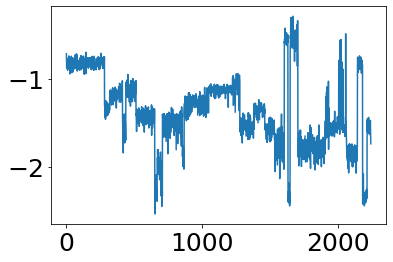

In [15]:
med_apo_feh = np.array([])
for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(gcsdr17['FE_H']>-100.))
    med_apo_feh = np.append(med_apo_feh,np.nanmedian(gcsdr17['FE_H'][clus]))
#     print('{}: {:.3f}'.format(gcs_clus[i],np.nanmedian(gcsdr17['FE_H'][clus])))
    
harris_dist = np.array([4.5,4.4,6.3,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,
                        9.6,8.9,4.9,8.6,17.4,16.0,5.9,9.9,4.0,7.4])*1000
harris_feh = np.array([-0.72,-1.56,-1.02,-1.37,-1.53,-2.37,-1.74,-1.65,-1.70,-1.50,-1.16,-1.29,-2.10,-1.49,-1.94,
                       -2.23,-0.78,-1.60,-2.31,-1.18,-1.14,-1.32,-1.59,-1.26,-2.27,-1.98,-0.45,-0.55,-1.54,-0.40])
harris_ext = np.array([0.04,0.28,0.33,0.19,0.02,0.10,0.38,0.06,0.34,0.01,0.35,0.03,0.02,0.15,0.08,0.05,0.25,0.01,
                       0.02,0.02,0.22,0.03,0.24,0.05,0.01,0.00,0.54,0.37,0.04,0.77])
vanden_feh = np.array([-0.76,-1.57,-1.03,-1.33,-1.58,-2.33,-1.53,-1.66,-1.70,-1.50,-1.18,-1.33,-2.06,-1.44,-1.93,
                       -2.27,-0.82,-1.60,-2.35,-1.18,-1.18,-1.32,-1.51,-1.30,-2.30,-2.31,-0.37,-0.77,-1.55,-0.60])
vanden_age = np.array([11.75,11.75,12.00,13.00,12.00,12.75,11.90,11.75,12.50,11.75,11.50,11.50,12.25,11.75,13.00,
                       12.00,11.00,11.0,12.75,11.00,11.00,11.50,11.50,11.75,12.25,12.50,11.25,12.03,12.50,11.26])

gcs_dist = 999999.0*np.ones(len(gcs))
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs_dist[clus] = harris_dist[i]
#     print(clus)

print('Harris-APOGEE:',np.median(harris_feh-med_apo_feh))
print('VandenBerg-APOGEE:',np.median(vanden_feh-med_apo_feh))
print('Overall:',np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))

shiftfeh = 999999*np.ones(len(gcsdr17))
for i in range(len(gcsdr17)):
    clus = np.where(gcs['CLUSTER']==gcs['CLUSTER'][i])
    if np.isfinite(gcsdr17['FE_H'][i])==False:
        shiftfeh[i] = (np.median(gcsdr17['FE_H'][clus])+
                       np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))
    else:
        shiftfeh[i] = (gcsdr17['FE_H'][i]+
                       np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))
        
plt.plot(shiftfeh)

In [16]:
def salaris(feh,cnalpha):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
    Inputs:
    ------
        feh: metallcity of a star
        cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
    Output:
    ------
            
    '''
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
    # assign solar value to stars if abundance is bad
    for j in range(len(cnalpha)):
        if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
            cnalpha[j] = 0.0
        
    if np.isfinite(feh)==False:
        feh = 0.0
    
    fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
    salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
    return salfeh

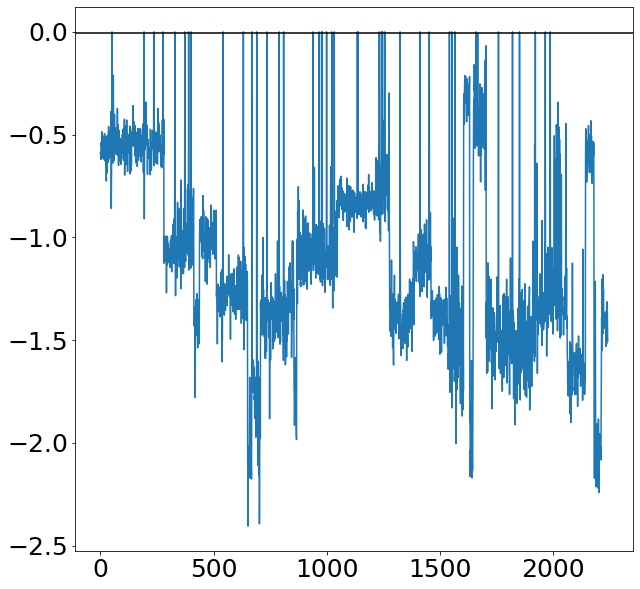

In [17]:
all_sal_feh = np.array([])
for i in range(len(gcsdr17)):
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
#     all_sal_feh = np.append(all_sal_feh,salaris(gcsdr17['FE_H'][i],cnalpha))
    all_sal_feh = np.append(all_sal_feh,salaris(shiftfeh[i],cnalpha))
    
plt.figure(figsize=[10,10])
plt.plot(all_sal_feh)
plt.axhline(-0.005,c='k')

# Gaia Errors

In [18]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

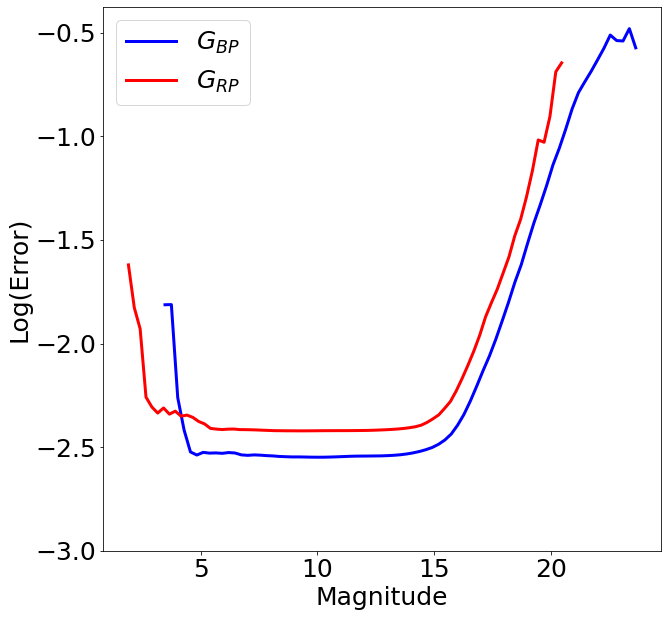

In [19]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

In [20]:
bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# Calculate Extinctions for Synthetic Stars 

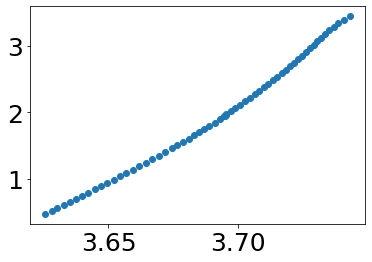

In [27]:
m22_harfeh = -1.70
m22_vanfeh = -1.70
isochr = massive[np.where((massive['MH']==closest(massive['MH'],m22_harfeh))&
                          (massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9))))]

plt.scatter(isochr['logTe'],isochr['logg'])

In [28]:
abp_ebv = cardelli_alav(leff['BP'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
arp_ebv = cardelli_alav(leff['RP'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
aj_ebv = cardelli_alav(leff['J'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
ah_ebv = cardelli_alav(leff['H'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))
ak_ebv = cardelli_alav(leff['K'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))

In [29]:
synteff = np.random.normal(10**isochr['logTe'],np.nanmedian(gcsdr17['TEFF_ERR']),len(isochr))
synfeh = np.random.normal(m22_vanfeh,np.nanmedian(gcsdr17['FE_H_ERR']),len(isochr))
synbpmag = np.random.normal(isochr['G_BPmag'],np.nanmedian(bperr),len(isochr))+5*np.log10(3200)-5.0
synrpmag = np.random.normal(isochr['G_RPmag'],np.nanmedian(rperr),len(isochr))+5*np.log10(3200)-5.0
synjmag = np.random.normal(isochr['Jmag'],np.nanmedian(gcsdr17['J_ERR']),len(isochr))+5*np.log10(3200)-5.0
synhmag = np.random.normal(isochr['Hmag'],np.nanmedian(gcsdr17['H_ERR']),len(isochr))+5*np.log10(3200)-5.0
synkmag = np.random.normal(isochr['Ksmag'],np.nanmedian(gcsdr17['K_ERR']),len(isochr))+5*np.log10(3200)-5.0

synbpmagext = np.random.normal(isochr['G_BPmag'],np.nanmedian(bperr),len(isochr))+5*np.log10(3200)-5.0+0.34*abp_ebv
synrpmagext = np.random.normal(isochr['G_RPmag'],np.nanmedian(rperr),len(isochr))+5*np.log10(3200)-5.0+0.34*arp_ebv
synjmagext = np.random.normal(isochr['Jmag'],np.nanmedian(gcsdr17['J_ERR']),len(isochr))+5*np.log10(3200)-5.0+0.34*aj_ebv
synhmagext = np.random.normal(isochr['Hmag'],np.nanmedian(gcsdr17['H_ERR']),len(isochr))+5*np.log10(3200)-5.0+0.34*ah_ebv
synkmagext = np.random.normal(isochr['Ksmag'],np.nanmedian(gcsdr17['K_ERR']),len(isochr))+5*np.log10(3200)-5.0+0.34*ak_ebv

synbpmagerr = np.random.normal(np.nanmedian(bperr),mad(bperr),len(isochr))
synrpmagerr = np.random.normal(np.nanmedian(rperr),mad(rperr),len(isochr))
synjmagerr = np.random.normal(np.nanmedian(gcsdr17['J_ERR']),mad(gcsdr17['J_ERR']),len(isochr))
synhmagerr = np.random.normal(np.nanmedian(gcsdr17['H_ERR']),mad(gcsdr17['H_ERR']),len(isochr))
synkmagerr = np.random.normal(np.nanmedian(gcsdr17['K_ERR']),mad(gcsdr17['K_ERR']),len(isochr))

In [30]:
print(r'ABP:',0.34*abp_ebv)
print(r'ARP:',0.34*arp_ebv)
print(r'AJ:',0.34*aj_ebv)
print(r'AH:',0.34*ah_ebv)
print(r'AK:',0.34*ak_ebv)

ABP: 1.124709839662325
ARP: 0.7108636729645033
AJ: 0.3163115748912041
AH: 0.20036213910716152
AK: 0.12702269926024454


In [53]:
### Lit Extinction
m22_litext = 999999.0*np.ones(len(isochr))
for i in tqdm_notebook(range(len(isochr))):
    
    cnalpha = np.array([0.,0.,0.,0.,0.,0.,0.,0.])
    phots = np.array([synbpmagext[i],synrpmagext[i],synjmagext[i],synhmagext[i],synkmagext[i]])
    phots_err = np.array([synbpmagerr[i],synrpmagerr[i],synjmagerr[i],synhmagerr[i],synkmagerr[i]])
    
    CalcAge = AetasStellae(synteff[i],synfeh[i],cnalpha,phots,phots_err,3200,massive)
    m22_litext[i] = CalcAge.k_extinction()
    

[41  1 85 76 74 33 84 84 16  6 27 70 85 62 94 91 78 94 81 65 69 75 53  3
 21 78 24 83 30 17 18 24 83 86 23 92 71 70 37 25 10 28 13 94 93 94 29 74
 31 67 59  8 22 64 42 53 48 69  0 37 57 37 25 68 81  2 60 45 26 37 35 26
  6 39 94 61 35 80 70 31 14 74 40 43 29 84 15 65 79 54  0 81 55 88 56 36
 33 45 17 65]
0
12.511128683236725
10.886429609016535
9.665334081612833
8.926195625965757
0.1256237044181934
1
12.515752920643246
10.88618737523515
9.677826130619891
8.95445585886982
0.12719925374156504
2
12.507166642160895
10.885232517052346
9.671656981276946
8.911893677833085
0.11739178416520285
3
12.51385520758493
10.873644756183861
9.652239585739704
8.934058014211534
0.12920009348803732
4
12.502258762329367
10.8828712747307
9.685933287216779
8.909739289251222
0.12500421372627202
5
12.513968282652982
10.882640113473132
9.678739083742808
8.976309567649428
999999.0
6
12.506961390340638
10.88313873468525
9.633088193832467
8.900810815328686
0.1235261885586138
7
12.506961390340638
10.88313873468525
9.

ValueError: setting an array element with a sequence.

In [54]:
m22_litext

array([999999., 999999., 999999., 999999., 999999., 999999., 999999.,
       999999., 999999., 999999., 999999., 999999., 999999., 999999.,
       999999., 999999., 999999., 999999., 999999., 999999., 999999.,
       999999., 999999., 999999., 999999., 999999., 999999., 999999.,
       999999., 999999., 999999., 999999., 999999., 999999., 999999.,
       999999., 999999., 999999., 999999., 999999., 999999., 999999.,
       999999., 999999., 999999., 999999., 999999., 999999., 999999.,
       999999., 999999., 999999., 999999., 999999., 999999., 999999.,
       999999., 999999., 999999., 999999., 999999., 999999.])